# Fitting transfer function of FS cell

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import erfc, erfcinv

In [8]:
range_exc = np.arange(1, 5,1)
range_inh = np.arange(5, 10,1)
FRout_exc =[]
i=0
for rate_exc in range_exc:
    print("rate exc =", rate_exc)
    FRout_exc.append([])
    for rate_inh in range_inh:
        FRout_exc[i].append(rate_exc+rate_inh)

    i+=1
		

rate exc = 1
rate exc = 2
rate exc = 3
rate exc = 4


In [12]:
np.array(FRout_exc).shape

(4, 5)

In [5]:

tau_e = 5.75 * 1e-3
Q_e = 0.5 * 1e-9
K_e = 1300

tau_i = 3.75 * 1e-3

tau_i1 = tau_i
Q_i1 = 0.24 * 0 * 1e-9
K_i1 = 0

tau_i2 = tau_i
Q_i2 = 1.1 * 1e-9
K_i2 = 25

g_L = 23.08 * 1e-9   # 30.0  /1.3
C_m = 255.45 * 1e-12  # 281.0 /1.1
E_L = -70.6 * 1e-3
E_e = 0.0
E_i = -85.0 * 1e-3
E_i1 = E_i2 = E_i

mu_0 = -60.0 * 1e-3
mu_d = 0.001
sig_0 = 0.004
sig_d = 0.006
tau_0 = 0.5
tau_d = 1.0

In [ ]:
#maria
ntot = 10000
gei = 0.2

tau_e = 5. * 1e-3
Q_e = 1.5 * 1e-9
K_e = (1-gei)*ntot

tau_i = 5. * 1e-3

tau_i1 = tau_i
Q_i1 = 0.24 * 0 * 1e-9
K_i1 = 0

tau_i2 = tau_i
Q_i2 = 1.5 * 1e-9
K_i2 = gei*ntot

g_L = 10 * 1e-9   # 30.0  /1.3
C_m = 200 * 1e-12  # 281.0 /1.1
E_L = -64 * 1e-3
E_e = 0.0
E_i = -80.0 * 1e-3
E_i1 = E_i2 = E_i

mu_0 = -60.0 * 1e-3
mu_d = 0.01
sig_0 = 0.004
sig_d = 0.006
tau_0 = 0.5
tau_d = 1.0

In [6]:
data0 = np.loadtxt('tf-na-fs.dat')
xdata0 = data0[:, 0:4]
xdata0[:, 0:3] += 1e-9  # to avoid 0/0 in tau_V
xdata0[:, 3] *= 1e-12  # TBC
ydata0 = data0[:, 4]
ydata0 += 1e-9

In [ ]:
feSim, fiSim, params = np.load(param_file,allow_pickle=True) 


In [ ]:
#maria
feSim, fiSim, params = np.load(param_file,allow_pickle=True) 

f_e = xdata[:, 0]
f_i1 = xdata[:, 1]
f_i2 = xdata[:, 2]
w_ad = xdata[:, 3]

data0 = np.loadtxt('tf-na-fs.dat')
xdata0 = data0[:, 0:4]
xdata0[:, 0:3] += 1e-9  # to avoid 0/0 in tau_V
xdata0[:, 3] *= 1e-12  # TBC
ydata0 = data0[:, 4]
ydata0 += 1e-9

In [2]:
def eff_thresh(mu_V, sig_V, tauN_V, params):
    P_0, P_mu, P_sig, P_tau, P_mu2, P_sig2, P_tau2, P_mu_sig, P_mu_tau, P_sig_tau = params
    V0 = P_0
    V1 = (P_mu * (mu_V - mu_0) / mu_d +
          P_sig * (sig_V - sig_0) / sig_d +
          P_tau * (tauN_V - tau_0) / tau_d)
    V2 = (P_mu2 * ((mu_V - mu_0) / mu_d)**2 +
          P_sig2 * ((sig_V - sig_0) / sig_d)**2 +
          P_tau2 * ((tauN_V - tau_0) / tau_d)**2 +
          P_mu_sig * ((mu_V - mu_0) / mu_d) * ((sig_V - sig_0) / sig_d) +
          P_mu_tau * ((mu_V - mu_0) / mu_d) * ((tauN_V - tau_0) / tau_d) +
          P_sig_tau * ((sig_V - sig_0) / sig_d) * ((tauN_V - tau_0) / tau_d))
    return V0 + V1 + V2

In [8]:
def mu_sig_tau_func(xdata):
    f_e = xdata[:, 0]
    f_i1 = xdata[:, 1]
    f_i2 = xdata[:, 2]
    w_ad = xdata[:, 3]
    
    mu_Ge = f_e * K_e * tau_e * Q_e
    sig_Ge = np.sqrt(0.5 * f_e * K_e * tau_e) * Q_e
    
    mu_Gi1 = f_i1 * K_i1 * tau_i1 * Q_i1
    sig_Gi1 = np.sqrt(0.5 * f_i1 * K_i1 * tau_i1) * Q_i1
    
    mu_Gi2 = f_i2 * K_i2 * tau_i2 * Q_i2
    sig_Gi1 = np.sqrt(0.5 * f_i2 * K_i2 * tau_i2) * Q_i2
    
    mu_G = mu_Ge + mu_Gi1 + mu_Gi2 + g_L
    tau_eff = C_m / mu_G
    
    mu_V = (mu_Ge * E_e + mu_Gi1 * E_i1 + mu_Gi2 * E_i2 + g_L * E_L - w_ad) / mu_G
    
    U_e = Q_e / mu_G * (E_e - mu_V)
    U_i1 = Q_i1 / mu_G * (E_i1 - mu_V)
    U_i2 = Q_i2 / mu_G * (E_i2 - mu_V)
    
    sig_V = np.sqrt(
        K_e * f_e * (U_e * tau_e)**2 / (2 * (tau_eff + tau_e)) +
        K_i1 * f_i1 * (U_i1 * tau_i1)**2 / (2 * (tau_eff + tau_i1)) +
        K_i2 * f_i2 * (U_i2 * tau_i2)**2 / (2 * (tau_eff + tau_i2))
    )
    
    tau_V = (
        (K_e * f_e * (U_e * tau_e)**2 +
         K_i1 * f_i1 * (U_i1 * tau_i1)**2 +
         K_i2 * f_i2 * (U_i2 * tau_i2)**2
        ) / 
        (K_e * f_e * (U_e * tau_e)**2 / (tau_eff + tau_e) +
         K_i1 * f_i1 * (U_i1 * tau_i1)**2 / (tau_eff + tau_i1) +
         K_i2 * f_i2 * (U_i2 * tau_i2)**2 / (tau_eff + tau_i2)
        )
    )

    return mu_V, sig_V, tau_V

In [9]:
def output_rate(params):
    f_out = erfc((eff_thresh(mu_V, sig_V, tauN_V, params) - mu_V) / (np.sqrt(2) * sig_V)) / (2 * tau_V)
    return f_out

In [10]:
def eff_thresh_estimate(ydata):
    Veff_thresh = mu_V + np.sqrt(2) * sig_V * erfcinv(ydata * 2 * tau_V)
    return Veff_thresh

In [11]:
def res_func(params):
    vthresh = eff_thresh(mu_V, sig_V, tauN_V, params)
    res = np.mean((Veff_thresh - vthresh)**2)
    return res

In [12]:
def res2_func(params):
    res2 = np.mean((output_rate(params) - ydata2)**2)
    return res2

In [13]:
# set globals
mu_V, sig_V, tau_V = mu_sig_tau_func(xdata0)
tauN_V = tau_V * g_L / C_m

In [14]:
Veff_thresh = eff_thresh_estimate(ydata0)
Veff_thresh

array([-0.07059964, -0.063523  , -0.05977302, -0.05673716, -0.05413129,
       -0.05183326, -0.0497739 , -0.04790819, -0.04620424, -0.05061258,
       -0.05060666, -0.05031859, -0.04988699, -0.04937025, -0.04881838,
       -0.04832413, -0.04794484, -0.04800534,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf, -0.06984229, -0.06376792, -0.06007193, -0.05706395,
       -0.05447446, -0.05218584, -0.05013113, -0.04826661, -0.04656126,
       -0.05069502, -0.05084705, -0.05043504, -0.05008606, -0.04959529,
       -0.04906264, -0.04858734, -0.04814511, -0.04788599, -0.04874419,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,      

In [18]:
selnan = np.where(np.isnan(Veff_thresh))
data2 = np.delete(data0, selnan, axis=0)

selnan = np.where(np.isinf(Veff_thresh))
data2 = np.delete(data2, selnan, axis=0)

In [19]:
xdata2 = data2[:, 0:4]
ydata2 = data2[:, 4]

In [20]:
# reset globals
mu_V, sig_V, tau_V = mu_sig_tau_func(xdata2)
tauN_V = tau_V * g_L / C_m
Veff_thresh = eff_thresh_estimate(ydata2)
Veff_thresh

array([-0.07059964, -0.063523  , -0.05977302, -0.05673716, -0.05413129,
       -0.05183326, -0.0497739 , -0.04790819, -0.04620424, -0.05061258,
       -0.05060666, -0.05031859, -0.04988699, -0.04937025, -0.04881838,
       -0.04832413, -0.04794484, -0.04800534, -0.06984229, -0.06376792,
       -0.06007193, -0.05706395, -0.05447446, -0.05218584, -0.05013113,
       -0.04826661, -0.04656126, -0.05069502, -0.05084705, -0.05043504,
       -0.05008606, -0.04959529, -0.04906264, -0.04858734, -0.04814511,
       -0.04788599, -0.04874419, -0.06975129, -0.0640188 , -0.06037301,
       -0.05739228, -0.05481947, -0.052541  , -0.05049192, -0.04862969,
       -0.04692409, -0.05112737, -0.05011331, -0.05053434, -0.0502064 ,
       -0.04976079, -0.04932592, -0.04887484, -0.04835272, -0.04798046,
       -0.04791804, -0.06977101, -0.06427312, -0.06067452, -0.05772053,
       -0.05516467, -0.052897  , -0.05085438, -0.04899539, -0.04729058,
       -0.04571781, -0.05017316, -0.05050261, -0.05018335, -0.04

In [21]:
params_init = np.ones(10) * 1e-3
#params_init[0] = Veff_thresh.mean()

In [22]:
fit = minimize(res_func, params_init, 
               method='SLSQP', options={'ftol': 1e-17, 'disp': True, 'maxiter':3000})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.0659038611088636e-06
            Iterations: 74
            Function evaluations: 907
            Gradient evaluations: 74


In [23]:
fit['x']

array([ 7.37469893e-02, -2.48481066e-03,  5.90565565e-01,  6.30976996e-02,
        1.02802482e-05,  6.75653199e-01,  1.91807742e-02, -6.86230341e-03,
       -4.73261252e-04,  1.71568181e-01])

In [24]:
params_init2 = fit['x']
res2_func(params_init2)

26.85681382611659

In [25]:
fit2 = minimize(res2_func, params_init2, 
                method='nelder-mead', options={'disp': True, 'maxiter':10000})

Optimization terminated successfully.
         Current function value: 1.976420
         Iterations: 690
         Function evaluations: 1033


In [26]:
fit2['x']

array([ 4.94629972e-02, -2.01089333e-03,  5.63358778e-01,  6.89641764e-02,
       -5.29502701e-06,  7.65033822e-01,  1.28431238e-02, -7.61864096e-03,
       -8.37159405e-04,  1.94583339e-01])

In [27]:
params = fit2['x']
res2_func(params)

1.9764203499172295

In [28]:
mean_error = np.mean(np.sqrt((data2[:, 4] - output_rate(params))**2))
mean_error

0.7451313197533288

In [23]:
#np.savetxt('fit-na-fs-params.dat', params)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

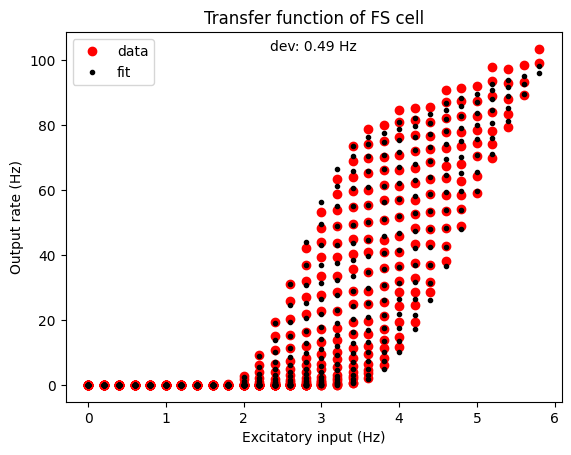

In [25]:
fig, ax = plt.subplots()
ax.set_title('Transfer function of FS cell')
ax.set_ylabel('Output rate (Hz)')
ax.set_xlabel('Excitatory input (Hz)')
    
inp_exc = data2[:, 0]
out_rate = data2[:, 4]
fit_rate = output_rate(params)
ax.plot(inp_exc, out_rate, 'ro', label='data')
ax.plot(inp_exc, fit_rate, 'k.', label='fit')

ax.text(0.5, 0.95, f'dev: {mean_error:.2f} Hz', transform=ax.transAxes, ha='center')
ax.legend();

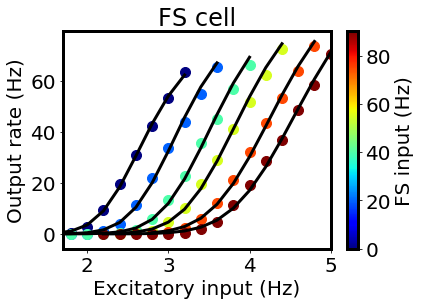

In [103]:
plt.rcParams.update({'font.size': 20})


fig, ax = plt.subplots()
ax.set_title('FS cell')
ax.set_ylabel('Output rate (Hz)')
ax.set_xlabel('Excitatory input (Hz)')
    

fs=[20,40,55,75,90,0]
#fs=np.ones(9)
#fs2=np.ones(11)*0.5

normalize = mcolors.Normalize(vmin=0, vmax=90)
colormap = cm.jet

    
inp_exc = data2[:, 0]
out_rate = data2[:, 4]
fit_rate = output_rate(params)

ax.scatter(inp_exc[0:17], out_rate[0:17], color=colormap(normalize(fs[5])), s=100)
ax.scatter(inp_exc[77:95], out_rate[77:95], color=colormap(normalize(fs[0])),s=100 )#'ro', label='data')
ax.plot(inp_exc[0:17], fit_rate[0:17], 'k',  linewidth=3.0, label='fit')
ax.plot(inp_exc[77:95], fit_rate[77:95], 'k',linewidth=3.0, label='fit')

ax.scatter(inp_exc[165:183], out_rate[165:183], color=colormap(normalize(fs[1])),s=100)# 'ro')
ax.plot(inp_exc[165:183], fit_rate[165:183], 'k',linewidth=3.0)


ax.scatter(inp_exc[245:256], out_rate[245:256], color=colormap(normalize(fs[2])),s=100)# 'ro')
ax.plot(inp_exc[245:256], fit_rate[245:256], 'k',linewidth=3.0)
ax.scatter(inp_exc[350:361], out_rate[350:361], color=colormap(normalize(fs[3])),s=100)# 'ro')
ax.plot(inp_exc[350:361], fit_rate[350:361], 'k',linewidth=3.0)
ax.scatter(inp_exc[430:445], out_rate[430:445], color=colormap(normalize(fs[4])),s=100)#'ro')
ax.plot(inp_exc[430:445], fit_rate[430:445], 'k',linewidth=3.0)

'''
#ax.plot(inp_exc[87:105], out_rate[87:105], 'ro')
#ax.plot(inp_exc[87:105], fit_rate[87:105], '-k.')
'''
ax.set_xlim(1.7,5)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(fs)
plt.colorbar(scalarmappaple, label='FS input (Hz)')


#plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.linewidth'] = 3


In [102]:
data2[80,2]

20.000000001

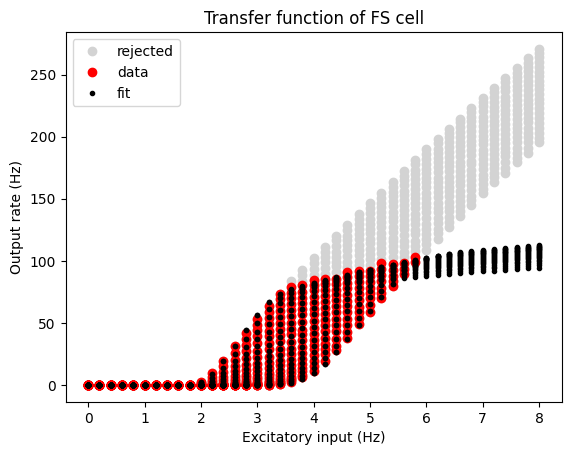

In [26]:
fig, ax = plt.subplots()
ax.set_title('Transfer function of FS cell')
ax.set_ylabel('Output rate (Hz)')
ax.set_xlabel('Excitatory input (Hz)')

inp_rej = data0[:, 0]
out_rej = data0[:, 4]
ax.plot(inp_rej, out_rej, 'o', color='lightgrey', label='rejected')
    
inp_exc = data2[:, 0]
out_rate = data2[:, 4]
fit_rate = output_rate(params)
ax.plot(inp_exc, out_rate, 'ro', label='data')
ax.plot(inp_exc, fit_rate, 'k.', label='fit')

# reset globals
mu_V, sig_V, tau_V = mu_sig_tau_func(xdata0)
tauN_V = tau_V * g_L / C_m
Veff_thresh = eff_thresh_estimate(ydata0)

inp_exc = data0[:, 0]
fit_rate = output_rate(params)
ax.plot(inp_exc, fit_rate, 'k.')
ax.legend();